In [97]:
import numpy as np
import pandas as pd # only used to read the MNIST data set
import networkx as nx
from datetime import datetime
import sklearn.tree
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import itertools
import random
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from sklearn.svm import SVC, LinearSVC
from tqdm import tqdm
import os
os.path.abspath(os.getcwd())

class Reservoir:
    def __init__(self,
                 graph,
                 readin_nodes = [],
                 readout_nodes = [],
                 spectral_radius = 0.9,
                 sparsity = None,
                 pca_reduce = False,
                 prediction_model = MLPRegressor,
                 prediction_model_kwargs = {"verbose":True, "hidden_layer_sizes":(20,)}):

        self.adjacency = graph
        self.prediction_model = prediction_model(**prediction_model_kwargs)
        # Wu should be initialised when .fit is called
        self.Wx = self.create_weights(spectral_radius=spectral_radius,
                                      sparsity=sparsity)
        self.Wu = None
        self.pca_reduce = pca_reduce
        self.readin_nodes = np.arange(graph.shape[0])
        self.readout_nodes = np.arange(graph.shape[0])

        if self.pca_reduce:
            self.pca = PCA(n_components=10)



    def create_weights(self, low=-1.0, high=1.0, sparsity=None, spectral_radius=None):
        shape = tuple(self.adjacency.shape)
        w = (high - low) * np.random.ranf(shape[0] * shape[1]).reshape(shape) + low  # create the weight matrix
        w[self.adjacency == 0] = 0.
        if not sparsity is None:  # if sparsity is defined
            s = np.random.ranf(shape[0] * shape[1]).reshape(shape) < (1.0 - sparsity)  # create a sparse boolean matrix
            w *= s  # set weight matrix values to 0.0
        if not spectral_radius is None:  # if spectral radius is defined
            sp = np.max(np.abs(np.linalg.eig(w)[0]))  # compute current spectral radius
            w *= (spectral_radius) / sp  # adjust weight matrix to acheive specified spectral radius
        return w


    def vis_graph(self, weights = None, name = "Reservoir_Graph", node_colours = None):
        if weights is not None:
            G = nx.from_numpy_matrix(np.matrix(weights), create_using=nx.Graph)
        else:
            G = nx.from_numpy_matrix(np.matrix(self.adjacency), create_using=nx.Graph)

        node_colours = node_colours if node_colours is not None else np.ones(G.order())

        print(f"Calculating positions for {G}")
        pos = nx.nx_pydot.graphviz_layout(G, prog = "sfdp")

        fig, ax = plt.subplots(figsize=(9,9))
        nx.draw_networkx_nodes(G, pos = pos,
                               node_size=100*node_colours,
                               node_color=node_colours)
        if weights is not None:
            weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
            print(f"Drawing edges")
            nx.draw_networkx_edges(G, pos = pos, width=weights, alpha = np.abs(weights), ax = ax)
        else:
            nx.draw_networkx_edges(G, pos = pos, alpha=0.1, width = 0.1, ax = ax)

        plt.savefig(f"{name}.png", dpi=600)
        # plt.show()

    def fit(self, series, targets):
        # Essentially training data, currently no warm-up
        embedded_states = self.forward(series)
        
        if self.pca_reduce:
            pca_embedded = self.pca.fit_transform(embedded_states)
        else:
            pca_embedded = embedded_states
        # print(embedded_states)
#         print(len(series), len(targets))
        self.prediction_model.fit(pca_embedded, targets)
        # plot_tree(self.prediction_model)
        # plt.show()


    def predict(self, series):
        assert self.Wu is not None, "Input weight matrix doesn't exist, must call .fit before .predict"
        embedded_states = self.forward(series)
        if self.pca_reduce:
            pca_embedded = self.pca.transform(embedded_states)
        else:
            pca_embedded = embedded_states
        prediction = self.prediction_model.predict(pca_embedded)

        return prediction, embedded_states


    # Alex's function for a simple reservoir operation - please sense check!
    def forward(self, input, remove_node_idxs=[]):
        self.Wu = np.zeros([self.Wx.shape[0], input.shape[0]])
        assert len(self.readin_nodes) != 0, f"no input nodes "
        self.Wu[self.readin_nodes, :] = 0.25
        # Input should be shape |V| x n_steps
        n_steps = input.shape[1]
        x_size = self.Wx.shape[0] # Network size

        assert self.Wu is not None, f"Wu has not been initialised, please call .fit"

        u_size = self.Wu.shape[1] # Input vector size
        x = np.zeros((x_size, 1))
        states = []
        for step in (range(n_steps)):
            # print(input.shape, u_size, self.Wu.shape)
            step_data = input[:, step].reshape((u_size, 1))

            # print(self.Wu.shape)
            # print(step_data)
            # print(np.vstack((1, step_data)))

            u = np.dot(self.Wu, step_data)
            # u = np.dot(self.Wu, np.vstack((1, step_data)))
            u[remove_node_idxs] = 0.

            x = np.tanh(u + np.dot((self.Wx+np.identity(x_size)), x))
            states += [x.flatten()]

            # if step == 0:
            #     x_state = (x)
            # else:
            #     x_state = np.hstack((x_state, x))
        assert len(self.readout_nodes) != 0, f"try reading nothing, its hard"
        return np.array(states)[:, self.readout_nodes]
    
def getData(steps, T, n_in_train, t0 = 0, noise_val = 0.025):
    # Time domain
    ts = np.linspace(t0,T, num=steps)

    t_noise = np.random.randn(steps)
    # Add more noise in non-train section
    t_noise *= noise_val

    # Data generating functions
    frequencies = np.cos(ts)
    amp_saved = np.sin(np.pi*frequencies) + t_noise
    # Shape stuff
    amplitudes = np.copy(amp_saved).reshape((1, -1))
    amplitudes = np.concatenate((amplitudes, amplitudes), axis=0)

    # test data is all the data to ensure network is contains the latent state initialising unseen states
    frequencies_test = frequencies
    frequencies_train = frequencies[:n_in_train]

    amplitudes_test = amplitudes
    amplitudes_train = amplitudes[:,:n_in_train]

    amp_saved_test = amp_saved
    amp_saved_train      = amp_saved[:n_in_train]
    
    return amplitudes_train, amplitudes_test, frequencies_train, frequencies_test

def sample_without_replacement(array, N):
    if N >= len(array):
        raise ValueError("N cannot be greater than or equal to the length of the array.")

    sampled_indices = np.random.choice(len(array), N, replace=False)
    sampled_elements = array[sampled_indices]

    return sampled_elements

In [2]:
fly_mat = pd.read_csv('science.add9330_data_s1_to_s4/Supplementary-Data-S1/all-all_connectivity_matrix.csv').drop(columns=['Unnamed: 0'])
fly_mat = fly_mat.to_numpy()
# Convert fly matrix into binary adjacency matrix
fly_mat[fly_mat > 0] = 1
fly_mat[fly_mat != 1] = 0
fly_mat[np.identity(fly_mat.shape[0], dtype=bool)] = 0.
fly_graph = fly_mat
print('fly density: ', np.sum(fly_mat.reshape(-1))/(fly_mat.shape[0]*fly_mat.shape[1]))
print(f"Fly graph {np.sum(fly_graph)} edges")

fly density:  0.012638989872283547


In [75]:
# initilise learning algorithm, this can be changed later
model = RandomForestRegressor
model_kwargs = {"n_estimators":20, "verbose":0, "n_jobs":2, "max_depth":5}
model_name = str(model).split('.')[-1].split("'")[0]
# Initialise reservoirs
fly_res = Reservoir(fly_graph, readout_nodes=[], prediction_model=model, prediction_model_kwargs=model_kwargs)

In [ ]:
# GNN DATA GENERATOR
n_in_train, n_test, noise = 2000, 1000, 0.025
total = n_in_train + n_test
amplitudes_train, amplitudes_test, frequencies_train, frequencies_test = getData(total, 8*np.pi, n_in_train, noise_val=noise)
       

In [149]:
                                                                          
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # fit learning components
    fly_res.readin_nodes = np.arange(fly_mat.shape[0])
    fly_res.readout_nodes = np.arange(fly_mat.shape[0])

    IN_NODES, OUT_NODES, TRAIN, TEST = [], [], [], []
    df = pd.DataFrame()
    for N_in in np.arange(100,700,100):
        #repeat number of samples of input nodes
        for readin_ID in range(1):
            #Sample a combination of nodes
            readin_nodes = sample_without_replacement(np.arange(fly_mat.shape[0]), N_in) 
            fly_res.readin_nodes = readin_nodes
            #Read full reservoir states
            full_res_states = fly_res.forward(amplitudes_test)

            for N_out in np.arange(100,700,100):
                #repeat number of samples of output nodes
                for readout_ID in tqdm(range(100)):
                    #sample a combination of output nodes
                    readout_nodes = sample_without_replacement(np.arange(fly_mat.shape[0]), N_out)
                    read_tr_states, read_te_states = full_res_states[:, readout_nodes][:n_in_train], full_res_states[:, readout_nodes][n_in_train:]
                    regressor = MLPRegressor(hidden_layer_sizes=20)
                    regressor.fit(read_tr_states, frequencies_train)
                    tr_predicted, te_predicted = regressor.predict(read_tr_states), regressor.predict(read_te_states)
                    train_perf, test_perf = mean_squared_error(tr_predicted, frequencies_train), mean_squared_error(te_predicted, frequencies_test[n_in_train:])
                    IN_NODES.append(readin_nodes)
                    OUT_NODES.append(readout_nodes)
                    TRAIN.append(train_perf)
                    TEST.append(test_perf)

    df['Input nodes'], df['Output nodes'] = IN_NODES, OUT_NODES
    df['Train MSE'], df['Test MSE'] = TRAIN, TEST

100%|█████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


In [153]:
df

,Input nodes,Output nodes,Train MSE,Test MSE
0,"[2191, 1457, 1194, 1113, 130, 1725, 395, 2300,...","[303, 41, 939, 2069, 992, 529, 2731, 1450, 133...",0.005877,0.483325
1,"[2191, 1457, 1194, 1113, 130, 1725, 395, 2300,...","[562, 2810, 2338, 2858, 2546, 454, 2262, 2617,...",0.009230,0.560773
2,"[2191, 1457, 1194, 1113, 130, 1725, 395, 2300,...","[414, 1797, 2200, 1424, 184, 2150, 2868, 2660,...",0.006478,0.419986
3,"[2191, 1457, 1194, 1113, 130, 1725, 395, 2300,...","[2100, 2392, 829, 1111, 690, 1627, 1368, 1779,...",0.006073,0.336775
4,"[2191, 1457, 1194, 1113, 130, 1725, 395, 2300,...","[2063, 300, 735, 1811, 1675, 1279, 2295, 2344,...",0.008004,0.296642
...,...,...,...,...
3595,"[811, 771, 2217, 1122, 2801, 2471, 2111, 844, ...","[2255, 2696, 2459, 226, 473, 2359, 2671, 2099,...",0.007137,0.473285
3596,"[811, 771, 2217, 1122, 2801, 2471, 2111, 844, ...","[1633, 1825, 10, 52, 1534, 731, 1218, 609, 836...",0.006710,0.590878
3597,"[811, 771, 2217, 1122, 2801, 2471, 2111, 844, ...","[1166, 2107, 2661, 1192, 2569, 687, 2883, 2776...",0.006574,0.792677
3598,"[811, 771, 2217, 1122, 2801, 2471, 2111, 844, ...","[2365, 2920, 2706, 2079, 1423, 272, 1382, 1687...",0.009396,0.768408


In [160]:
np.std(df['Test MSE']), np.min(df['Test MSE']), np.max(df['Test MSE']),np.median(df['Test MSE']), np.mean(df['Test MSE'])

(0.20368263032261688,
 0.14469445577207501,
 3.0482851886274913,
 0.43973231187082756,
 0.4835089508284293)

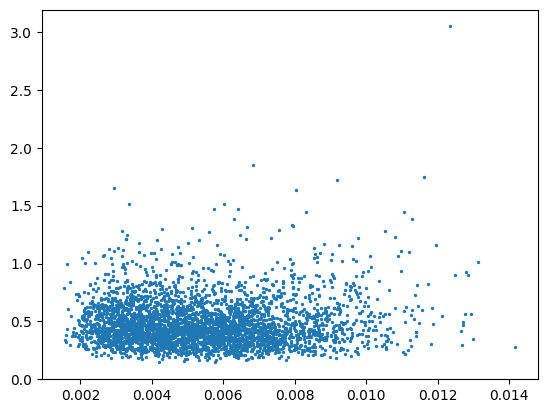

In [154]:
x, y = df['Train MSE'], df['Test MSE']
plt.scatter(x,y, s =2)

In [152]:
df.to_csv('GNN_data/initial_MLP_data2.csv')

In [155]:
pd.DataFrame(fly_res.Wx).to_csv('GNN_data/Wx_initial_MLP_data.csv')